In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [4]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [21]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        if self.training:
            if x.ndim == 2:
                dim = (0)
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

# Not equal to Flatten in pytorch
class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        fD, sD, tD = x.shape
        x = x.view(fD, sD//self.n, tD*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [22]:
n_embd = 10
n_hidden_layers = 68


model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(2), Linear(n_embd * 2, n_hidden_layers, bias=False), BatchNorm1D(n_hidden_layers), Tanh(),
    Flatten(2), Linear(n_hidden_layers * 2, n_hidden_layers, bias=False), BatchNorm1D(n_hidden_layers), Tanh(),
    Flatten(2), Linear(n_hidden_layers * 2, n_hidden_layers, bias=False), BatchNorm1D(n_hidden_layers), Tanh(),
    Linear(n_hidden_layers, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


22397


In [28]:
for layer in model.layers:
    print(layer.__class__.__name__, "->", tuple(layer.out.shape)) 

Embedding -> (1, 8, 10)
Flatten -> (1, 4, 20)
Linear -> (1, 4, 68)
BatchNorm1D -> (1, 4, 68)
Tanh -> (1, 4, 68)
Flatten -> (1, 2, 136)
Linear -> (1, 2, 68)
BatchNorm1D -> (1, 2, 68)
Tanh -> (1, 2, 68)
Flatten -> (1, 136)
Linear -> (1, 68)
BatchNorm1D -> (1, 68)
Tanh -> (1, 68)
Linear -> (1, 27)


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    

    logits = model(Xb)        
    loss = F.cross_entropy(logits, Yb)
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2912
  10000/ 200000: 2.1906
  20000/ 200000: 2.2263
  30000/ 200000: 2.2117
  40000/ 200000: 2.4755
  50000/ 200000: 2.0309
  60000/ 200000: 2.0950
  70000/ 200000: 1.9959
  80000/ 200000: 1.9089
  90000/ 200000: 1.6285
 100000/ 200000: 2.1211
 110000/ 200000: 2.1506
 120000/ 200000: 1.8746
 130000/ 200000: 1.9748
 140000/ 200000: 1.8431
 150000/ 200000: 1.7267
 160000/ 200000: 1.9099
 170000/ 200000: 1.5729
 180000/ 200000: 2.0037
 190000/ 200000: 1.7964


In [24]:
for layer in model.layers:
    layer.training = False

In [25]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9207327365875244
val 2.0261080265045166


In [26]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))
    

brincan.
rosey.
emmalie.
derrie.
lone.
carlina.
phanilyn.
ronojay.
ghylarah.
rhitree.
embriya.
gormanja.
nyla.
arhee.
jahci.
zhernan.
booloden.
giavnetce.
korian.
ayvion.


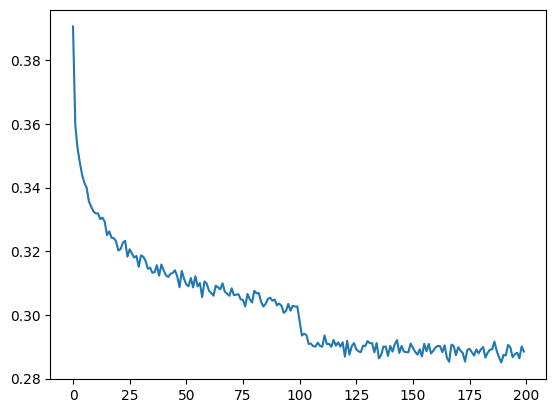

In [29]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))